### Setup

In [1]:
# Import required libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy as sp

In [2]:
# Set time range of 24 years
t = pd.date_range(start='31/10/2000', end='31/10/2024', freq='ME')

# Define column names for the equities
equity_columns = [
    'JOHNSON & JOHNSON',
    'BOSTON SCIENTIFIC',
    'ELI LILLY',
    'PFIZER', 
    'TELEFLEX',
    'CIGNA',
    'REVVITY',
    'MEDTRONIC', 
    'LABCORP HOLDINGS',
    'HUMANA'
    ]
    
# Generate lists for total return indices and market value indices
equity_TRI_columns = [f"{name} - TOT RETURN IND" for name in equity_columns]
equity_MV_columns  = [f"{name} - MARKET VALUE"   for name in equity_columns]

### Assignment 1

In [3]:
#-----------------------------------------------------------------------------------------------------------------------------------#
# Interest rates

# Download risk free interest rates (skipping rows 1,2 because they are not actual market values but additional information)
rF_yearly = pd.read_excel('INTEREST_RATE.xlsx', usecols=['US FEDERAL FUNDS RATE (MONTHLY AVERAGE) NADJ'], skiprows=[1, 2], header=0)

# Verify there are no NaN values in the DataFrame
assert not rF_yearly.isnull().values.any(), "DataFrame contains NaN values"

# Adding a missing value for October 2024, required since other files contain this data. 
# Source: https://www.federalreserve.gov/releases/h15/
rF_yearly.loc[len(rF_yearly)] = 4.92

# Compute monthly rates
rF = np.array(rF_yearly / 12)

#-----------------------------------------------------------------------------------------------------------------------------------#
# Market indices

# Download overall equity market index
health_MKT = pd.read_excel('STOXX_HEALTH_PI.xlsx', usecols=['STOXX NTH AMER 600 HEALTH CARE E - PRICE INDEX'])

# Verify there are no NaN values in the DataFrame
assert not health_MKT.isnull().values.any(), "DataFrame contains NaN values"

# Conversion in percentual montlhy variance
rMKT = 100 * (np.log(health_MKT) - np.log(health_MKT.shift(1)))

# Drop the first row (since log returns are computed as difference between consecutive data, first row will be NaN)
# Calculation of Excess Market Returns from risk-free Market Returns
rMKT = np.array(rMKT[1:])
eMKT = np.subtract(rMKT, rF[1:])

#-----------------------------------------------------------------------------------------------------------------------------------#
# Market value of constituents

# Download market value of constituents
mkt_value = pd.read_excel('MKT_VALUE.xlsx', usecols=equity_MV_columns, skiprows=[1, 2], header=0)
# Reorder the columns explicitly to match the correct order 
mkt_value = mkt_value[equity_MV_columns]

# Verify there are no NaN values in the DataFrame
assert not mkt_value.isnull().values.any(), "DataFrame contains NaN values"

#-----------------------------------------------------------------------------------------------------------------------------------#
# Equities

# Download equities
data = pd.read_excel('Stocks_Constituents.xlsx', usecols=equity_TRI_columns)
# Reorder the columns explicitly to match the correct order 
data = data[equity_TRI_columns]
# Verify there are no NaN values in the DataFrame
assert not data.isnull().values.any(), "DataFrame contains NaN values"

### Assignment 2

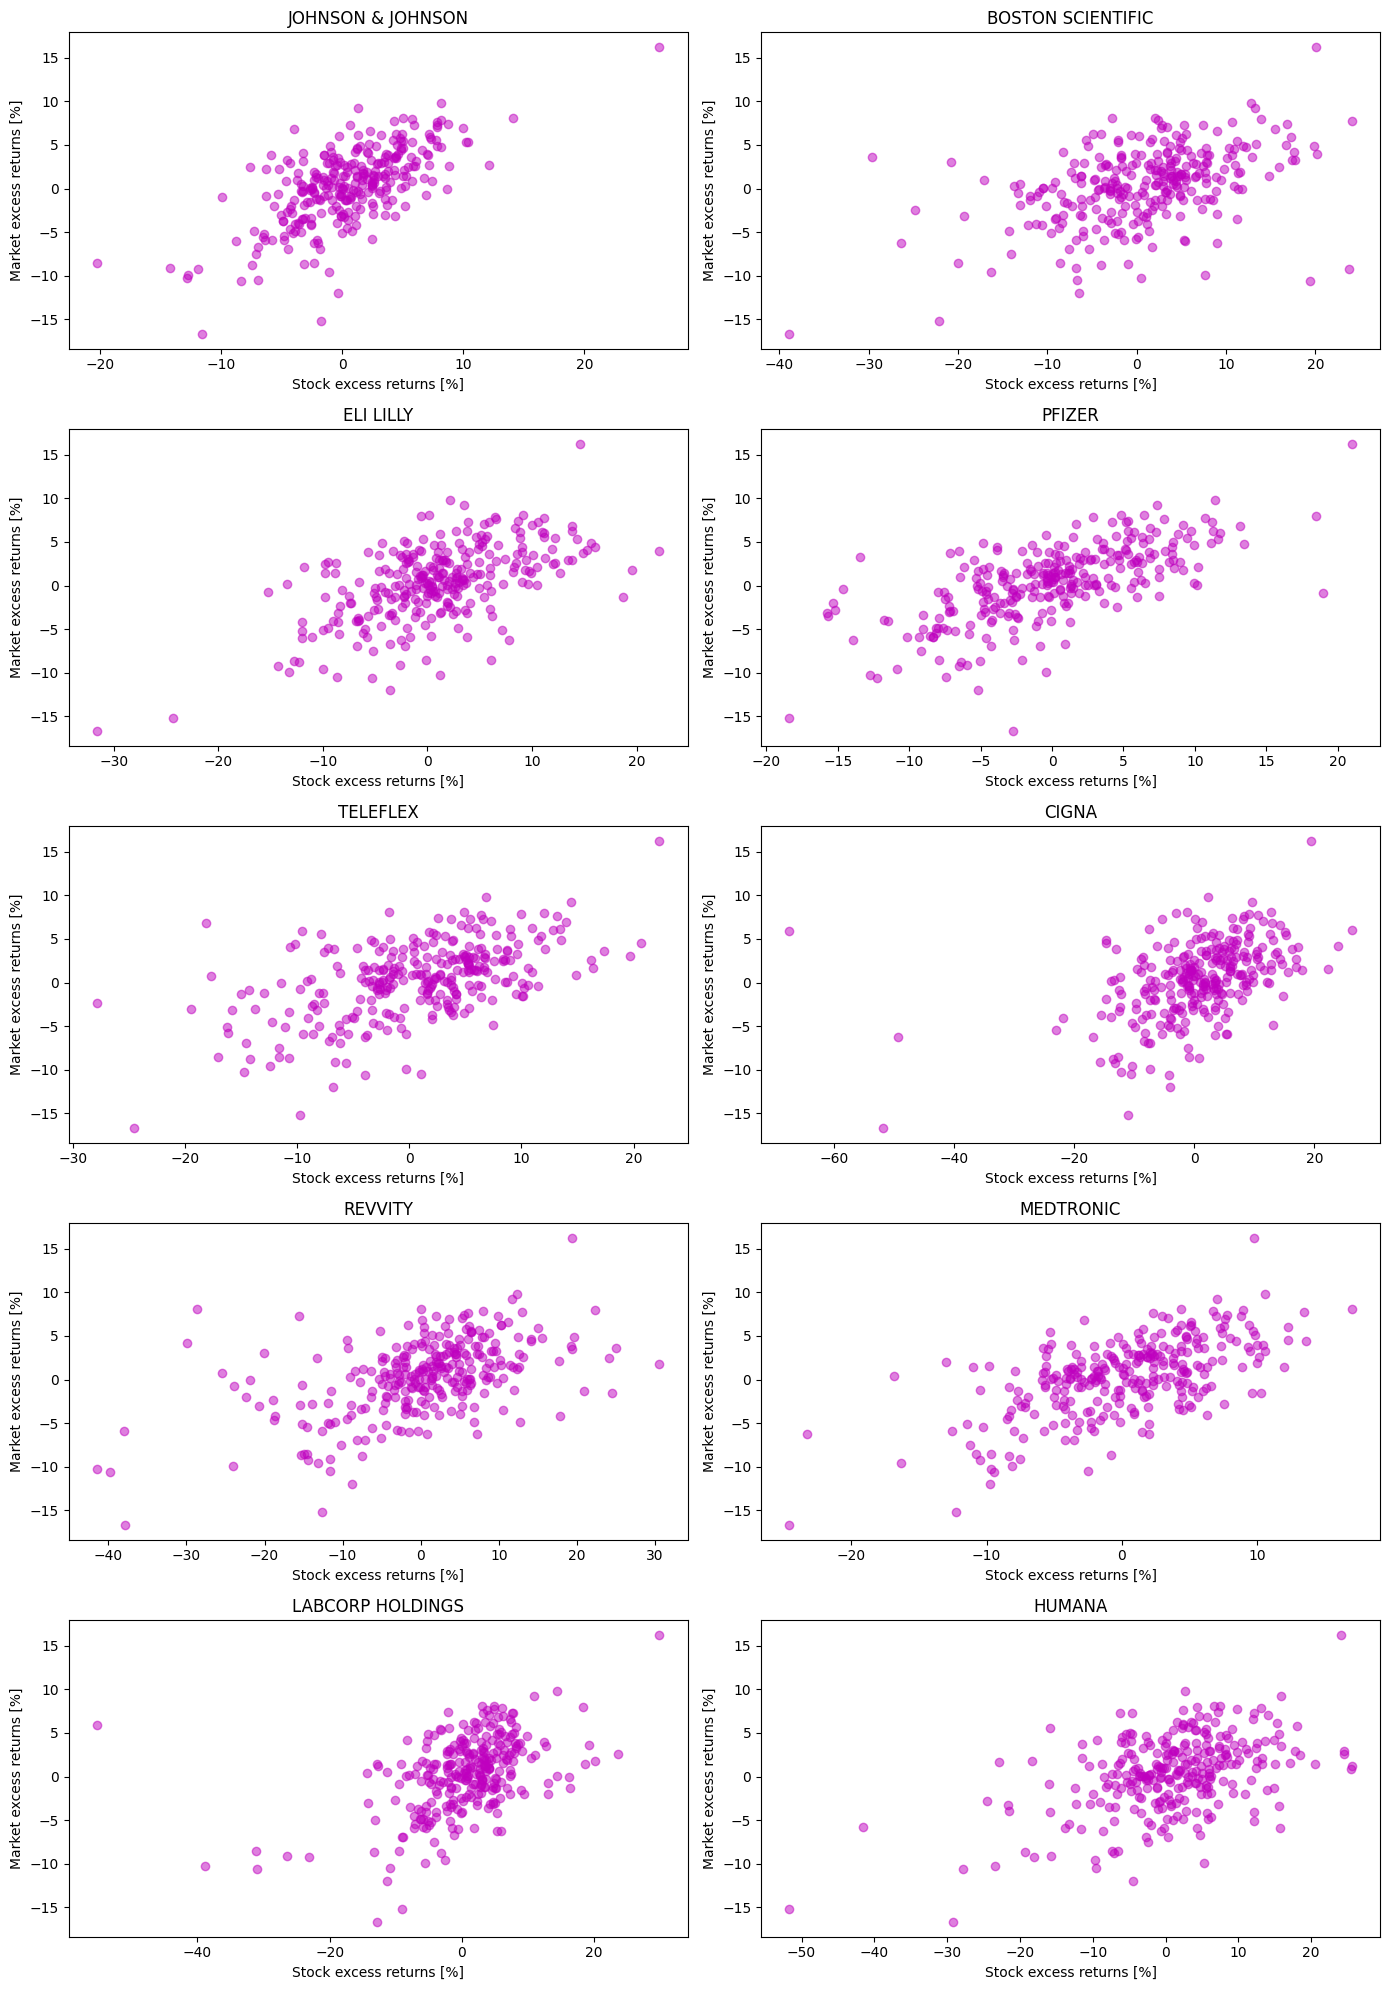

In [4]:
# Calculate the log returns for all equities
log_returns = 100 * (np.log(data) - np.log(data.shift(1)))

# Drop the first row (since log returns are computed as difference between consecutive data, first row will be NaN)
log_returns = log_returns.iloc[1:]

# Verify there are no other NaN values in the DataFrame
assert not log_returns.isnull().values.any(), "DataFrame contains NaN values"

# Broadcasting rF across columns in log_return to create the result dataframe
eEquities = log_returns.sub(rF[1:], axis=0)

#-----------------------------------------------------------------------------------------------------------------------------------#
# Create scatter plots

# Get number of equities
num_equities = eEquities.shape[1]  

# Calculate the number of rows needed with two plots per row (creating an extra row if there's an odd number of equities)
num_rows  = (num_equities + 1) // 2  

# Create the figure and axis grid
fig, axes = plt.subplots(num_rows, 2, figsize=(14, 4 * num_rows))
# Flatten the grid for easy indexing
axes      = axes.flatten() 

# Loop through each equity column and create a scatter plot
for i, column in enumerate(eEquities.columns):
    axes[i].scatter(eEquities[column], eMKT, alpha=0.5, color='m')
    axes[i].set_title(equity_columns[i])
    axes[i].set_xlabel('Stock excess returns [%]')
    axes[i].set_ylabel('Market excess returns [%]')

# Hide any unused subplots if the number of equities is odd
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Make sure the layout is pretty
plt.tight_layout()
plt.show()

### Assignment 3

In [5]:
# Adds an intercept (constant) term to eMKT
eMKT_with_const   = sm.add_constant(eMKT)

# Perform regressions
regression_models = [sm.OLS(eEquities[column], eMKT_with_const).fit() for column in eEquities.columns]

# Define the file name
output_file       = "stocks_regression_summaries.txt"

# Open the file in write mode
with open(output_file, "w") as f:
    for i, model in enumerate(regression_models):
        # Write the equity name and the summary to the file
        f.write(f"Summary for {equity_columns[i]}:\n")
        # Convert the summary to a string format
        f.write(model.summary().as_text())
        # Separator between summaries to improve readability
        f.write("\n\n" + "<->:"*24 + "\n\n")  

print(f"Regression summaries have been saved to {output_file}")


Regression summaries have been saved to stocks_regression_summaries.txt


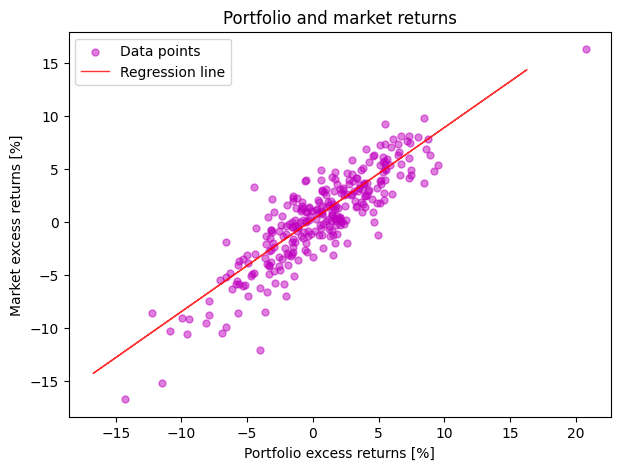

In [16]:
#-----------------------------------------------------------------------------------------------------------------------------------#
# Perform linear regression on the portfolio

# Compute the weights
weights           = mkt_value.div(mkt_value.sum(axis=1), axis=0)
# Rename columns in both DataFrames so that pandas doesn't cry when performing element-wise multilpication 
weights.columns   = equity_columns
eEquities.columns = equity_columns
# Compute weighted average
avg_return        = weights[1:] * eEquities
# Sum across columns to get the portfolio return for each row
ePortfolio        = avg_return.sum(axis=1)

# Perform regression 
regression_model  = sm.OLS(ePortfolio, eMKT_with_const).fit()

#-----------------------------------------------------------------------------------------------------------------------------------#
# Produce a scatterplot

plt.figure(figsize=(7, 5))
plt.scatter(ePortfolio, eMKT, alpha=0.5, color='m', s=25, label='Data points')
plt.plot(eMKT, regression_model.fittedvalues, color='red', linewidth=1, alpha=0.8, label="Regression line")
plt.legend()
plt.xlabel("Portfolio excess returns [%]")
plt.ylabel("Market excess returns [%]")
plt.title("Portfolio and market returns")
plt.savefig('portfolio_regression.png', dpi=300)
plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------#
# Save summary in external file

output_file = 'portfolio_regression_summary.txt'

with open(output_file, "w") as f:
    f.write(f"Summary for Porfolio:\n")
    # Convert the summary to a string format
    f.write(model.summary().as_text())

### Assignment 5

In [7]:
#-----------------------------------------------------------------------------------------------------------------------------------#
# Perform chow test 

# Specify the degrees of freedom of the model
dof = 2
# Initialize the list that will contain the P-values of all equities
Pvals = []
# Define the total number of data points for each equity
T = len(eEquities)
# Set minimum dimension of subset to use for unrestricted models
width = int(0.15 * T)
# Set extremes of the intervals for regression
begin = width
end = T - width

# Loop over equities 
for column in eEquities.columns:
    # Perform regression on the whole dataset for the considered equity
    Res1 = sm.OLS(eEquities[column][1:T], eMKT_with_const[1:T]).fit()
    # Compute residual sum of squares for restricted model
    RSSR = Res1.ssr
    # Preemptively allocate memory to store the results in order to speed up computations
    Fstat = np.empty(end - begin - 1, dtype=float)  # Adjust size to skip the first date
    Pval = np.empty(end - begin - 1, dtype=float)   # Adjust size to skip the first date

    # Loop for dates within interval, starting from begin + 1 to skip the first date
    for i, date in enumerate(range(begin + 1, end)):
        X1 = np.column_stack((np.ones_like(eMKT[1:date]), eMKT[1:date]))
        X2 = np.column_stack((np.ones_like(eMKT[date + 1:T]), eMKT[date + 1:T]))
        
        # Compute residual sum of squares for unrestricted model as sum of residuals of the two regressions
        res2A = sm.OLS(eEquities[column][1:date], X1).fit()
        res2B = sm.OLS(eEquities[column][date + 1:T], X2).fit()
        RSSU = res2A.ssr + res2B.ssr
        
        # Save Fstat and Pval for the adjusted index `i`
        Fstat[i] = ((RSSR - RSSU) / dof) / (RSSU / (T - 2 * dof))
        Pval[i] = 1 - sp.stats.f.cdf(Fstat[i], dof, T - 2 * dof)

    # Append P-values to list of results for all equities
    Pvals.append(Pval)


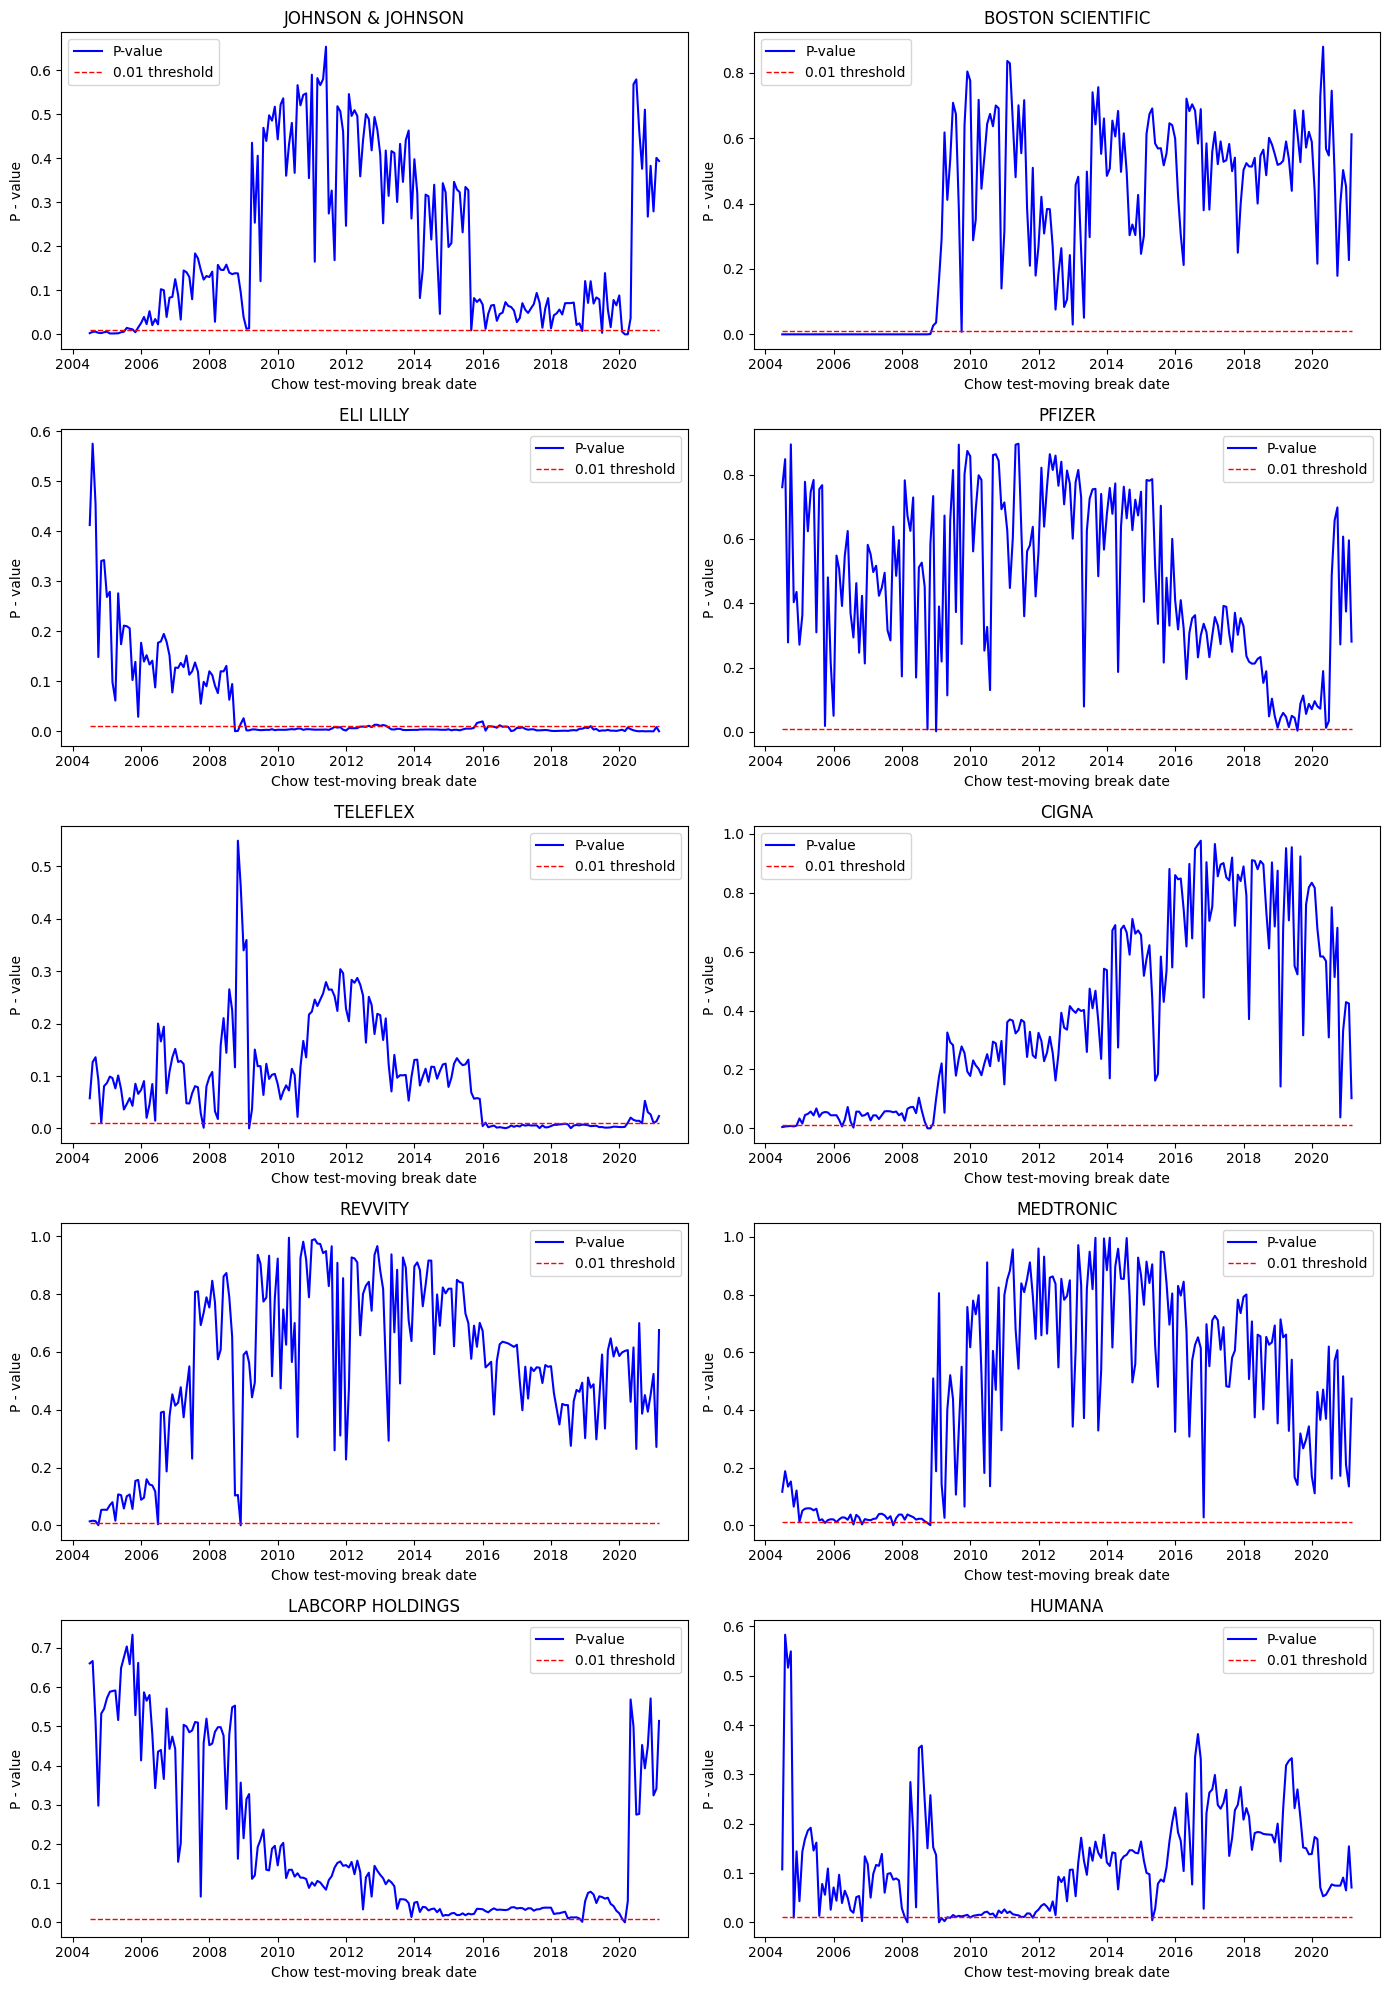

In [9]:
#-----------------------------------------------------------------------------------------------------------------------------------#
# Plot results

# Get the number of equities
num_equities = 10
# Calculate the number of rows needed with two plots per row
num_rows  = (num_equities + 1) // 2
# Create the figure and axis grid
fig, axes = plt.subplots(num_rows, 2, figsize=(14, 4 * num_rows))
# Flatten the grid for easy indexing
axes      = axes.flatten() 
# Select the subset of dates to use as x axis
t_subset = t[begin + 1:end]
# Plot each equity's p-values with the date-based x-axis
for i, (pvals, column) in enumerate(zip(Pvals, eEquities.columns)):
    # Plot p-values for each equity on its respective axis using the date range
    axes[i].plot(t_subset, pvals, label="P-value", color="b")
    axes[i].plot(t_subset, 0.01 * np.ones_like(pvals), label="0.01 threshold", color="r", linestyle="--", linewidth=1)
    
    # Label the plot and add a title
    axes[i].set_title(f"{column}")
    axes[i].set_xlabel('Chow test-moving break date')
    axes[i].set_ylabel('P - value')
    axes[i].legend()
    
# Remove any empty subplots if the number of equities is odd
if num_equities % 2 != 0:
    fig.delaxes(axes[-1])

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('chowmoving.png', dpi=300)
plt.show()